# Практика SQL. Анализ данных StackOverflow

Вы будете работать с базой данных StackOverflow — сервиса вопросов и ответов о программировании. StackOverflow похож на социальную сеть — пользователи сервиса задают вопросы, отвечают на посты, оставляют комментарии и ставят оценки другим ответам.  
Вы будете работать с версией базы, где хранятся данные о постах за 2008 год, но в таблицах вы найдёте информацию и о более поздних оценках, которые эти посты получили.  


Вам нужно написать несколько SQL-запросов.  

Необходимые данные находятся в таблицах схемы `stackoverflow`.  

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine 

### Конфигурация для подключения к базе данных `data-analyst-advanced-sql`
Эта база данных содержит схему `stackoverflow`, с которой вы будете работать в проекте

In [2]:
db_config = {
    'user': USER_NAME', # имя пользователя
    'pwd': PASSWORD', # пароль
    'host': HOST,
    'port': 6432, # порт подключения
    'db': 'data-analyst-advanced-sql' # название базы данных
}  

connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(
    db_config['user'],
    db_config['pwd'],
    db_config['host'],
    db_config['port'],
    db_config['db'],
)

Создание подключения

In [3]:
engine = create_engine(connection_string) 

# Задание 1

Выведите общую сумму просмотров постов за каждый месяц 2008 года. Если данных за какой-либо месяц в базе нет, такой месяц можно пропустить. Результат отсортируйте по убыванию общего количества просмотров.

| month_date  | total_views |
| ------------- | ------------- |
| 2008-09-01  | 452928568  |
| 2008-10-01  | 365400138  |
| ...         | ... |

In [6]:
# напишите запрос
query = '''
SELECT DISTINCT DATE_TRUNC('month', creation_date) AS month_date,
       SUM(views_count) OVER (PARTITION BY DATE_TRUNC('month', creation_date) ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS total_views
FROM stackoverflow.posts
WHERE EXTRACT('year' FROM creation_date::date) = 2008
ORDER BY total_views DESC
'''

# выполните запрос

In [7]:
df_1 = pd.read_sql_query(query, con=engine, index_col='month_date') 
df_1

,total_views
month_date,
2008-09-01,452928568
2008-10-01,365400138
2008-11-01,221759651
2008-12-01,197792841
2008-08-01,131367083
2008-07-01,669895


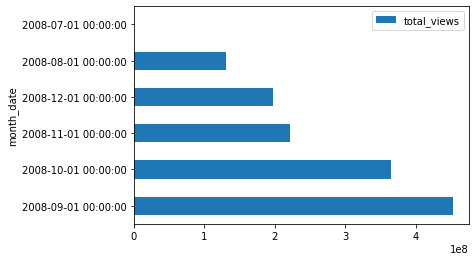

In [8]:
df_1.plot.barh();

**Проанализируйте итоговую таблицу. Отличаются ли данные за разные месяцы? С чем могут быть связаны отличия?**

Наибольшее количество просмотров постов приходится на месяцы: сентябрь, октябрь, ноябрь, декабрь. Наименьшее количество - на июль и август. Это может быть связано с тем, что с сентября начинается учебный год и потребность в информации, представленной на сервисе, становится более острой, нежели в неучебное время (летом).  

Информация о просмотрах с января по июнь вовсе отсутсвует, возможно, по причине того, что сам сервис stackoverflow появился лишь в 2008 году.

# Задание 2

Выведите имена самых активных пользователей, которые в первый месяц после регистрации (включая день регистрации) дали больше 100 ответов. Вопросы, которые задавали пользователи, не учитывайте. Для каждого имени пользователя выведите количество уникальных значений `user_id`. Отсортируйте результат по полю с именами в лексикографическом порядке.

| display_name | count |
| ------------ | ----- |
| 1800 INFORMATION | 1 |
| Adam Bellaire | 1 |
| Adam Davis | 1 |
| ... | ... |

In [31]:
# напишите запрос
query = '''
WITH base_tbl AS (SELECT u.id AS usr_id,
                         u.display_name, 
                         COUNT(p.id) OVER (PARTITION BY p.user_id) AS posts_per_user,
                         u.creation_date AS user_creation_date,
                         u.creation_date + INTERVAL '1 month' AS plus_one_month,
                         p.creation_date AS post_creation_date
                  FROM stackoverflow.posts AS p 
                       LEFT JOIN stackoverflow.post_types AS pt ON p.post_type_id = pt.id
                       LEFT JOIN stackoverflow.users AS u ON u.id = p.user_id
                  WHERE pt.type = 'Answer'
                  ORDER BY posts_per_user)
                
SELECT display_name,
       COUNT(DISTINCT usr_id)
FROM (SELECT display_name, 
             usr_id,
             posts_cnt
      FROM (SELECT usr_id,
                   display_name, 
                   posts_per_user,
                   user_creation_date,
                   plus_one_month,
                   post_creation_date,
                   COUNT(*) OVER (PARTITION BY usr_id) AS posts_cnt
            FROM base_tbl
            WHERE post_creation_date <= plus_one_month
            ) tbl
      WHERE posts_cnt > 100
      ) tbl1
GROUP BY display_name
ORDER BY display_name
'''

# выполните запрос

In [33]:
df_2 = pd.read_sql_query(query, con=engine) 
df_2

,display_name,count
0,1800 INFORMATION,1
1,Adam Bellaire,1
2,Adam Davis,1
3,Adam Liss,1
4,Amy B,1
...,...,...
57,leppie,1
58,lomaxx,1
59,mattlant,1
60,paxdiablo,1


In [11]:
df_2['count'].unique()

array([1])

Какие аномалии наблюдаются в данных? О чём они говорят?

У каждого имени пользователя лишь 1 уникальный айди. Аномалий не наблюдается.

# Задание 3

Выведите количество постов за 2008 год по месяцам. Отберите посты от пользователей, которые зарегистрировались в сентябре 2008 года и сделали хотя бы один пост в декабре того же года. Отсортируйте таблицу по значению месяца по убыванию.

| month | count |
| ------|------ |
| 2008-12-01 | 17641 |
| 2008-11-01 | 18294 |
| ... | ... |

In [12]:
# напишите запрос
query = '''
WITH tbl AS (SELECT DISTINCT user_id, 
                    COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', creation_date::date)) AS num_posts_dec
             FROM stackoverflow.posts
             WHERE DATE_TRUNC('month', creation_date::date) = '2008-12-01')

SELECT DISTINCT DATE_TRUNC('month', p.creation_date) AS month,
       COUNT(*) OVER (PARTITION BY DATE_TRUNC('month', p.creation_date::date))
FROM stackoverflow.posts AS p 
     LEFT JOIN stackoverflow.users AS u ON u.id = p.user_id
     RIGHT JOIN tbl ON tbl.user_id = p.user_id
WHERE EXTRACT('year' FROM p.creation_date::date) = 2008
      AND DATE_TRUNC('month', u.creation_date::date) = '2008-09-01'
      AND tbl.num_posts_dec <> 0
ORDER BY month DESC
'''

# выполните запрос

In [13]:
df_3 = pd.read_sql_query(query, con=engine) 
df_3

,month,count
0,2008-12-01,17641
1,2008-11-01,18294
2,2008-10-01,27171
3,2008-09-01,24870
4,2008-08-01,32


Изучите данные: есть ли в них аномалии? Предположите, почему могли появиться аномальные значения.

Да, есть аномальные значения.  
В таблице присутствует 32 пользователя, которые зарегестрировались в сентябре, однако их посты были сделаны в августе.  
Одна из причин, почему так могло получиться: пользователи на самом деле зарегестрировались в августе, и сделали посты в августе, однако, возможно, данные об их регистрации попали на сервер с опозданием и им была присвоена дата регистрации более поздняя, чем дата их поста.

# Задание 4

Используя данные о постах, выведите несколько полей:

- идентификатор пользователя, который написал пост;
- дата создания поста;
- количество просмотров у текущего поста;
- сумму просмотров постов автора с накоплением.

Данные в таблице должны быть отсортированы по возрастанию идентификаторов пользователей, а данные об одном и том же пользователе — по возрастанию даты создания поста.

| user_id | creation_date | views_count | cumulative_count |
| ------ | -------------- | ----------- | ---------------- |
| 1 | 2008-07-31 23:41:00  | 480476   | 480476  |
| 1 | 2008-07-31 23:55:38  | 136033 | 616509  | 
| 1 | 2008-07-31 23:56:41  | 0 |  616509  |
| ... | ... | ... | ... |
| 2 | 2008-07-31 23:56:41 | 79087  | 79087 |
| 2 | 2008-08-01 05:09:56 | 65443 | 144530 |
| ... | ...  | ...  | ...  |

In [14]:
# напишите запрос
query = '''
SELECT user_id,
       creation_date,
       views_count,
       SUM(views_count) OVER (PARTITION BY user_id ORDER BY creation_date ASC)
FROM stackoverflow.posts
ORDER BY user_id ASC, creation_date ASC
'''

# выполните запрос

In [15]:
df_4 = pd.read_sql_query(query, con=engine) 
df_4

,user_id,creation_date,views_count,sum
0,1,2008-07-31 23:41:00,480476,480476
1,1,2008-07-31 23:55:38,136033,616509
2,1,2008-07-31 23:56:41,0,616509
3,1,2008-08-04 02:45:08,0,616509
4,1,2008-08-04 04:31:03,0,616509
...,...,...,...,...
243791,5696608,2008-12-23 16:00:37,0,2804
243792,5696608,2008-12-23 17:35:09,0,2804
243793,5696608,2008-12-24 01:02:48,0,2804
243794,5696608,2008-12-30 14:34:45,0,2804


# Задание 5

Найдите среднее количество постов пользователей в день за август 2008 года. Отберите данные о пользователях, которые опубликовали больше 120 постов за август. Дни без публикаций не учитывайте. 

Отсортируйте результат по возрастанию среднего количества постов. Значения можно не округлять.

| user_id | avg_daily |
| ------- | --------- |
| 116     | 4.777778  |
| 234     | 5.208333  |
| ...     | ... |

In [16]:
# напишите запрос
query = '''
SELECT DISTINCT user_id,
       AVG(posts_per_day::float) OVER (PARTITION BY user_id) AS avg_daily
FROM (SELECT DISTINCT user_id,
             creation_date::date,
             COUNT(*) OVER (PARTITION BY user_id, creation_date::date) AS posts_per_day
      FROM stackoverflow.posts
      WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
      ) tbl1
WHERE user_id IN (SELECT user_id
                  FROM (SELECT DISTINCT user_id,
                               COUNT(*) OVER (PARTITION BY user_id) AS posts_per_month
                        FROM stackoverflow.posts
                        WHERE DATE_TRUNC('month', creation_date) = '2008-08-01'
                        ) tbl
                  WHERE posts_per_month > 120)
ORDER BY avg_daily
'''

# выполните запрос

In [17]:
df_5 = pd.read_sql_query(query, con=engine) 
df_5

,user_id,avg_daily
0,116,4.777778
1,234,5.208333
2,91,5.681818
3,905,7.000000
4,383,7.277778


# Задание 6

Сколько в среднем дней в период с 1 по 7 декабря 2008 года пользователи взаимодействовали с платформой? Для каждого пользователя отберите дни, в которые он или она опубликовали хотя бы один пост. Нужно получить одно целое число — не забудьте округлить результат. 

| result |
| -----  |
| <целое число> |

In [18]:
# напишите запрос
query = '''
WITH tbl AS (SELECT user_id, 
                    creation_date::date, 
                    COUNT(*)
            FROM stackoverflow.posts
            WHERE creation_date::date BETWEEN '2008-12-01' AND '2008-12-07'
            GROUP BY user_id, creation_date::date)
            
SELECT ROUND(SUM(usr_num_days) / COUNT(DISTINCT user_id)) AS result
FROM (SELECT DISTINCT user_id,
             COUNT(creation_date) OVER (PARTITION BY user_id) AS usr_num_days
      FROM tbl
      WHERE count <> 0) AS tbl2
'''

# выполните запрос

In [19]:
df_6 = pd.read_sql_query(query, con=engine) 
df_6

,result
0,2.0


Проанализируйте итоговую таблицу — какие выводы можно сделать?

В период с 1-го по 7-е декабря каждый пользователь в среднем взаимодествовал с платформой 2 дня.

# Задание 7

Выведите историю активности каждого пользователя в таком виде: идентификатор пользователя, дата публикации поста. Отсортируйте вывод по возрастанию идентификаторов пользователей, а для каждого пользователя — по возрастанию даты публикации.

Добавьте в таблицу новое поле: для каждого поста в нём будет указано название месяца предпоследней публикации пользователя относительно текущей. Если такой публикации нет, укажите `NULL`.  Python автоматически поменяет `NULL` на `None`, но дополнительно преобразовывать значения `None` вам не нужно.

Посмотрите внимательно на образец таблицы: для первых двух постов предпоследней публикации нет, но, начиная с третьего поста, в новое поле входит нужный месяц. Для следующего пользователя в первые две записи поля `second_last_month` тоже войдёт `NULL`.

| user_id | creation_date | second_last_month |
| ------- | ------------- | ----------------- |
| 1       | 2008-07-31 23:41:00 | None |
| 1       | 2008-07-31 23:55:38 | None |
| 1       | 2008-07-31 23:56:41 | July |
| 1       | 2008-08-04 02:45:08 | July |
| 1       | 2008-08-04 04:31:03 | July |
| 1       | 2008-08-04 08:04:42 | August |
| ... | ... | ... |

In [20]:
# напишите запрос
query = '''
SELECT user_id, 
       creation_date,
       CASE LAG(EXTRACT('month' FROM creation_date::date), 2) OVER (PARTITION BY user_id ORDER BY creation_date)
            WHEN 7 THEN 'July'
            WHEN 8 THEN 'August'
            WHEN 9 THEN 'September'
            WHEN 10 THEN 'October'
            WHEN 11 THEN 'November'
            WHEN 12 THEN 'December'
       END
          
FROM stackoverflow.posts
ORDER BY user_id ASC, creation_date ASC
'''

# выполните запрос

In [21]:
df_7 = pd.read_sql_query(query, con=engine) 
df_7

,user_id,creation_date,case
0,1,2008-07-31 23:41:00,None
1,1,2008-07-31 23:55:38,None
2,1,2008-07-31 23:56:41,July
3,1,2008-08-04 02:45:08,July
4,1,2008-08-04 04:31:03,July
...,...,...,...
243791,5696608,2008-12-23 16:00:37,December
243792,5696608,2008-12-23 17:35:09,December
243793,5696608,2008-12-24 01:02:48,December
243794,5696608,2008-12-30 14:34:45,December


# Задание 8

Рассчитайте аналог Retention Rate по месяцам для пользователей StackOverflow. Объедините пользователей в когорты по месяцу их первого поста. Возвращение определяйте по наличию поста в текущем месяце. 

| cohort_dt | session_date | users_cnt | cohort_users_cnt | retention_rate |
| --- | --- | --- | --- | --- |
| 2008-07-01 00:00:00 | 2008-07-01 00:00:00 | 3 | 3 | 100 |
| 2008-07-01 00:00:00 | 2008-08-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-09-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-10-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-07-01 00:00:00 | 2008-11-01 00:00:00 | 1 | 3 | 33,33 |
| 2008-07-01 00:00:00 | 2008-12-01 00:00:00 | 2 | 3 | 66,67 |
| 2008-08-01 00:00:00 | 2008-08-01 00:00:00 | 2151 | 2151 | 100 |
| ... | ... | ... | ... | ... |

In [22]:
# напишите запрос
query = '''
WITH c AS (SELECT user_id,
                  cohort_dt
           FROM (SELECT user_id, 
                        FIRST_VALUE(DATE_TRUNC('month', creation_date)) OVER (PARTITION BY user_id ORDER BY creation_date) AS cohort_dt
                 FROM stackoverflow.posts) cohorts
           GROUP BY user_id, cohort_dt),
            
     s AS (SELECT user_id,
                  DATE_TRUNC('month', creation_date) AS month_of_post,
                  COUNT(*)
            FROM stackoverflow.posts
            GROUP BY user_id,  DATE_TRUNC('month', creation_date))
            
SELECT tbl.cohort_dt,
       tbl.session_date,
       tbl.users_cnt,
       FIRST_VALUE(tbl.users_cnt) OVER (PARTITION BY tbl.cohort_dt ORDER BY tbl.session_date) AS cohort_users_cnt,
       ROUND(1.0 * tbl.users_cnt / FIRST_VALUE(tbl.users_cnt) OVER (PARTITION BY tbl.cohort_dt ORDER BY tbl.session_date) * 100, 2) AS retention_rate
FROM (
      SELECT c.cohort_dt,
             s.month_of_post AS session_date,
             COUNT(c.user_id) AS users_cnt
      FROM c JOIN s ON c.user_id = s.user_id
      GROUP BY c.cohort_dt, s.month_of_post
      ) AS tbl
ORDER BY tbl.cohort_dt, tbl.session_date
'''

# выполните запрос

In [23]:
df_8 = pd.read_sql_query(query, con=engine) 
df_8

,cohort_dt,session_date,users_cnt,cohort_users_cnt,retention_rate
0,2008-07-01,2008-07-01,3,3,100.00
1,2008-07-01,2008-08-01,2,3,66.67
2,2008-07-01,2008-09-01,1,3,33.33
3,2008-07-01,2008-10-01,2,3,66.67
4,2008-07-01,2008-11-01,1,3,33.33
5,2008-07-01,2008-12-01,2,3,66.67
6,2008-08-01,2008-08-01,2151,2151,100.00
7,2008-08-01,2008-09-01,1571,2151,73.04
8,2008-08-01,2008-10-01,1275,2151,59.27
9,2008-08-01,2008-11-01,1050,2151,48.81


Постройте тепловую карту Retention Rate. Какие аномалии или другие необычные явления удалось выявить? Сформулируйте гипотезы о возможных причинах.

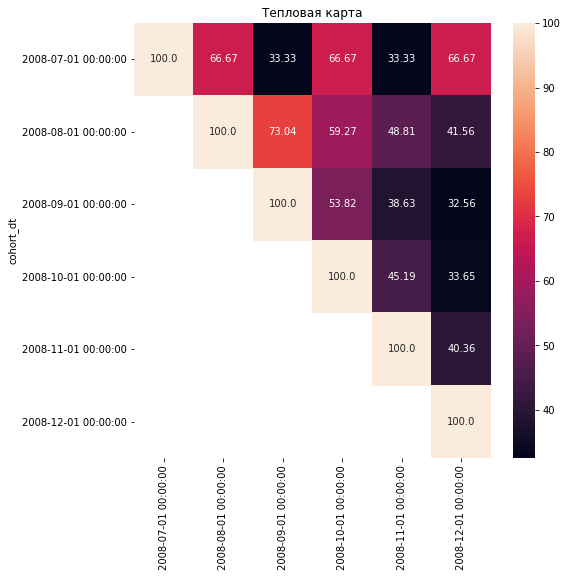

In [24]:
# постройте тепловую карту Retention Rate
retention = df_8.pivot('cohort_dt', 'session_date', 'retention_rate')
retention.index = [str(x) for x in retention.index]
retention.columns = [str(x) for x in retention.columns]

plt.figure(figsize=(8, 8)) # задаём размер графика
sns.heatmap(retention, annot=True, fmt='')
plt.ylabel('session_date')
plt.ylabel('cohort_dt')
plt.title('Тепловая карта') # название графика
plt.show() 

Опишите аномалии или другие необычные явления и сформулируйте гипотезы

- Нет необходимости анализировать данные по когорте пользователей за июль, так как в их числе всего лишь 3 человека.  
- Наибольший возврат пользователей на следующий месяц был в когорте тех, кто сделал свой первый пост в августе. 73% сделали еще как минимум 1 пост в сентябре. Это может быть связано с началом учебного года.  
- Чем ближе дата когорты пользователей к концу года, тем меньше retention_rate на следующий месяц. Видимо, к концу календарного года потребность в сервисе среди пользователей снижается.

# Задание 9


На сколько процентов менялось количество постов ежемесячно с 1 сентября по 31 декабря 2008 года? Отобразите таблицу со следующими полями:

- номер месяца;
- количество постов за месяц;
- процент, который показывает, насколько изменилось количество постов в текущем месяце по сравнению с предыдущим.

Если постов стало меньше, значение процента должно быть отрицательным, если больше — положительным. Округлите значение процента до двух знаков после запятой.

Напомним, что при делении одного целого числа на другое в PostgreSQL в результате получится целое число, округлённое до ближайшего целого вниз. Чтобы этого избежать, переведите делимое в тип `numeric`.

| creation_month | posts_count | percentage |
| -------------- | ----------- | ---------- |
| 9 | 70731 | Nan |
| 10 | 63102 | -10.33 |
| ... | ... | ... |

In [25]:
# напишите запрос
query = '''
SELECT creation_month,
       posts_count,
       ROUND(
              (
                (posts_count - LAG(posts_count) OVER (ORDER BY creation_month))::float / 
                LAG(posts_count) OVER (ORDER BY creation_month) *
                100
               )::numeric, 2
             ) AS percentage
FROM (SELECT DISTINCT EXTRACT('month' FROM creation_date)::int AS creation_month,
             COUNT(id) OVER (PARTITION BY EXTRACT('month' FROM creation_date)) AS posts_count
      FROM stackoverflow.posts
      WHERE creation_date::date BETWEEN '2008-09-01' AND '2008-12-31') tbl
'''

# выполните запрос

Постройте круговую диаграмму с количеством постов по месяцам.

In [26]:
df_9 = pd.read_sql_query(query, con=engine, index_col='creation_month') 
df_9

,posts_count,percentage
creation_month,,
9,70371,NaN
10,63102,-10.33
11,46975,-25.56
12,44592,-5.07


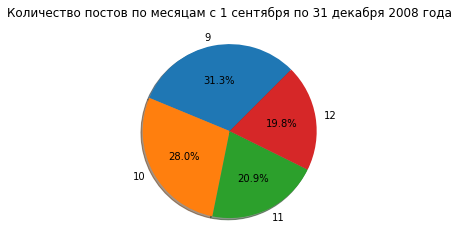

In [27]:
# постройте круговую диаграмму с количеством постов по месяцам
plt.pie(df_9.posts_count, labels=df_9.index, autopct='%1.1f%%', shadow=True, startangle=45)
plt.title('Количество постов по месяцам с 1 сентября по 31 декабря 2008 года')
plt.show();

# Задание 10

Выгрузите данные активности пользователя, который опубликовал больше всего постов за всё время. Выведите данные за октябрь 2008 года в таком виде:

- номер недели;
- дата и время последнего поста, опубликованного на этой неделе.

| week_creation | creation_date |
| ------------- | ------------- |
| 40 | 2008-10-05 09:00:58 |
| 41 | 2008-10-12 21:22:23 |
| ... | ... |

In [36]:
# напишите запрос
query = '''
SELECT DISTINCT EXTRACT('week' FROM creation_date)::int AS week_creation,
       LAST_VALUE(creation_date) OVER (PARTITION BY EXTRACT('week' FROM creation_date) ORDER BY creation_date ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS creation_date
FROM stackoverflow.posts
WHERE DATE_TRUNC('month', creation_date) = '2008-10-01'
      AND user_id = (SELECT DISTINCT FIRST_VALUE(user_id) OVER  (ORDER BY posts_cnt DESC)
                     FROM (SELECT DISTINCT user_id,
                                  COUNT(id) OVER (PARTITION BY user_id) AS posts_cnt
                           FROM stackoverflow.posts
                           ) tbl
                     )

'''

# выполните запрос

In [37]:
df_10 = pd.read_sql_query(query, con=engine, index_col='week_creation') 
df_10

,creation_date
week_creation,
40,2008-10-05 09:00:58
41,2008-10-12 21:22:23
42,2008-10-19 06:49:30
43,2008-10-26 21:44:36
44,2008-10-31 22:16:01
